In [1]:
import csv
import pandas as pd
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_curve, recall_score, f1_score, roc_auc_score, precision_score
from sklearn.externals import joblib
import matplotlib.pyplot as plt
import datetime
from random import randint
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/home/rashi/anaconda3/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['randint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
# Reading saved csv file
df_feat = pd.read_csv('data/DataTables/features.csv', sep=',', header=None)
# data table actually exists a directory above the views.py file
df_feat.columns = df_feat.iloc[0]
# Use first row info as header
df_feat.drop(df_feat.index[0], inplace=True)
# Drop first row
df_feat.drop(df_feat.columns[[0]], axis=1, inplace=True)
# removing the first column of NaNs that shows up from reading csv. Don't ask why. Sigh.

cols = df_feat.columns.drop('ReadingDt')
df_feat[cols] = df_feat[cols].apply(pd.to_numeric, errors='coerce')
df_feat.dtypes

0
PtID            int64
Gender          int64
Weight        float64
Height        float64
ReadingDt      object
ExStat          int64
BeforeEx        int64
AfterEx         int64
Episode         int64
MeanSensor    float64
MeanManual    float64
StdSensor     float64
StdManual     float64
MeanDiff      float64
StdDiff       float64
Peaks           int64
ExDiff          int64
BMI           float64
dtype: object

In [3]:
df = df_feat.dropna(axis=0, how='any')
# drop NaN values

patients = df['PtID'].as_matrix().astype(int)
dates = df['ReadingDt'].as_matrix().astype(str)
np.savetxt('files/patients.dat', patients, fmt="%d")
np.savetxt('files/dates.dat', dates, fmt="%s")

y = df['Episode']
y = y.as_matrix().astype(int)
indices = np.arange(len(y))
print(len(y[y==1]), len(y[y==0]))

df = df.drop(['PtID','ReadingDt'], axis=1)
# since already saved these as separate arrays for identification
df = df.drop('Gender', axis=1)
# since it gave 0 importance!!

df.drop(['Episode'],axis=1,inplace=True)
# 'Episode' is target only, so drop it from features!

50 81


In [4]:
x = df.as_matrix()

features = np.array(df.columns.astype(str))
np.savetxt('files/features.dat', features, fmt="%s")
print(features)
print(shape(x))

['Weight' 'Height' 'ExStat' 'BeforeEx' 'AfterEx' 'MeanSensor' 'MeanManual'
 'StdSensor' 'StdManual' 'MeanDiff' 'StdDiff' 'Peaks' 'ExDiff' 'BMI']
(131, 14)


In [5]:
from sklearn.model_selection import train_test_split

######################### Building Training and Testing Datasets ##############################
x_train, x_test, y_train, y_test, ind_train, ind_test = train_test_split(x, y, indices, test_size=0.25, random_state=42, stratify=y)
# stored indices to reference specific patients and dates later

np.savetxt('files/x_train.dat', x_train) ; np.savetxt('files/y_train.dat', y_train)
np.savetxt('files/x_test.dat', x_test) ; np.savetxt('files/y_test.dat', y_test)
np.savetxt('files/ind_train.dat', ind_train) ; np.savetxt('files/ind_test.dat', ind_test)

print("train:",len(y_train[y_train==1]), len(y_train[y_train==0]))
print("test:",len(y_test[y_test==1]), len(y_test[y_test==0]))

train: 37 61
test: 13 20


#### best recall: 0.762040816327
#### best n_estimators: 210
#### best min_sample_leaf: 2
#### best warm_start: False
#### best max_depth 7
#### best max_features: 7

In [6]:
######################################### Training Forest ####################################################
def train_rf(x_train, y_train, trees_rf, samples_rf, warm_rf, depth_rf, features_rf):
  model = RandomForestClassifier(min_samples_leaf=samples_rf, oob_score=True, n_estimators=trees_rf, 
                                 warm_start = True, max_depth = depth_rf, max_features=features_rf)
  model.fit(x_train,y_train)
  return model

model = train_rf(x_train, y_train, 50, 2, False, 7, 10)
joblib.dump(model,'test_models/model.pkl') 

['test_models/model.pkl']

In [7]:
########################################### Testing ####################################################
def testing(x_test, model):
  y_pred = model.predict(x_test)
  prob = model.predict_proba(x_test) # To get confidence of the prediction
  return np.array(y_pred), np.array(prob)

y_pred, prob = testing(x_test, model)

In [8]:
def plot_confusion_matrix(cm, ylabel, xlabel):
  plt.figure()
  cmap = plt.cm.Oranges
  plt.imshow(cm, interpolation='nearest', cmap=cmap)
  plt.title('Normalized Confusion Matrix', fontsize=16)
  plt.colorbar()
  for (i, j), z in np.ndenumerate(cm):
    if(z<0.5):
        color = 'k'
    else:
        color = 'w' # hard to read black on dark backgrounds
    plt.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', color=color, fontsize=16)
# write cm values on grid
  tick_labels = ['no episode', 'episode']
  tick_marks = np.arange(len(tick_labels))
  plt.xticks(tick_marks, tick_labels, fontsize=13, rotation=45)
  plt.yticks(tick_marks, tick_labels, fontsize=13)
  plt.tight_layout()
  plt.ylabel(ylabel, fontsize=16)
  plt.xlabel(xlabel, fontsize=16)

def plot_hist(prob_meta, prob_prec):
  fig = plt.figure()
  ax1 = fig.add_subplot(211)
  ax2 = fig.add_subplot(212)

  results, edges = np.histogram(prob_meta, bins=np.linspace(0,1,21,endpoint=True) , normed=True)
  binWidth = edges[1] - edges[0]
  ax1.bar(edges[:-1], results*binWidth, binWidth, facecolor='b', label = 'No Episode')  

  results, edges = np.histogram(prob_prec, bins=np.linspace(0,1,21,endpoint=True), normed=True)
  binWidth = edges[1] - edges[0]
  ax2.bar(edges[:-1], results*binWidth, binWidth, facecolor='r', label = 'Episode')

  ax1.set_xlim(0,1)
  ax2.set_xlim(0,1)
  ax1.set_ylim(0,0.5)
  ax2.set_ylim(0,0.5)

  plt.suptitle('Spread of Classification Probabilities', fontsize=15)
  ax1.set_ylabel('Probability', fontsize=15)
  ax2.set_ylabel('Probability', fontsize=15)
  ax2.set_xlabel('Episode Classification Probability', fontsize=15)
  ax1.legend(loc='best', fontsize=20)
  ax2.legend(loc='best', fontsize=20)
  #plt.tight_layout()

correct predictions (0 in 0 & 1 in 1): 78.79
mean probabilities = for 0: 0.59 & for 1: 0.41
Confusion Matrix true_pred:
 [[18  2]
 [ 5  8]]
oob_score 0.63
recall_score 0.62
precision_score 0.8
f1_score 0.7
roc_auc_score 0.76


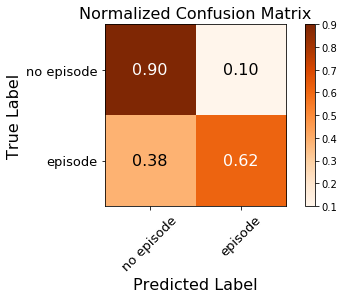

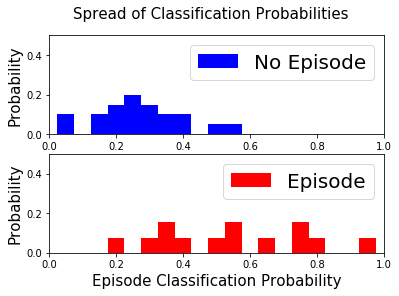

In [9]:
################################################# Prediction & Performance ################################################# 
def prediction(x_test, y_test, y_pred, prob, model):
  cm_true_pred = confusion_matrix(y_test, y_pred, labels = [0, 1])
  ncm_true_pred = cm_true_pred.astype('float') / cm_true_pred.sum(axis=1)[:, np.newaxis]
# Normalize the confusion matrix by row (i.e by the number of samples in each class)

  print("correct predictions (0 in 0 & 1 in 1):", np.round((cm_true_pred[0][0]+cm_true_pred[1][1])*100.0/np.sum(cm_true_pred), 2))
  print("mean probabilities = for 0:", np.round(np.mean(prob[:,0]), 2), '& for 1:', np.round(np.mean(prob[:,1]), 2))
  print("Confusion Matrix true_pred:\n", cm_true_pred)
  plot_confusion_matrix(ncm_true_pred, 'True Label', 'Predicted Label')

  print("oob_score", np.round(model.oob_score_, 2))
  print("recall_score", np.round(recall_score(y_test, y_pred, average='binary'), 2))
  print("precision_score", np.round(precision_score(y_test, y_pred, average='binary'), 2))
  print("f1_score", np.round(f1_score(y_test, y_pred, average='binary'), 2))
  print("roc_auc_score", np.round(roc_auc_score(y_test, y_pred), 2))
  
# plot 1D histogram of hypo '1' probabilities in '0' and '1' regions:
  prob_0 = prob[y_test == 0, 1]
  prob_1 = prob[y_test == 1, 1]
  plot_hist(prob_0, prob_1)

prediction(x_test, y_test, y_pred, prob, model)

Feature ranking:
1. feature 2 (0.006256)
2. feature 9 (0.024134)
3. feature 11 (0.024687)
4. feature 4 (0.029729)
5. feature 12 (0.046725)
6. feature 3 (0.054210)
7. feature 10 (0.056372)
8. feature 13 (0.056626)
9. feature 7 (0.058007)
10. feature 1 (0.069005)
11. feature 0 (0.070838)
12. feature 5 (0.073026)
13. feature 8 (0.203401)
14. feature 6 (0.226983)


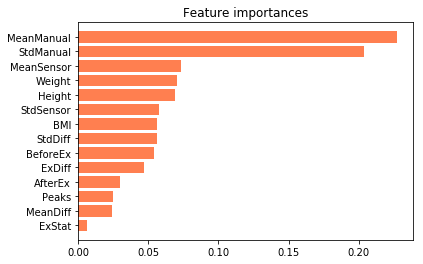

In [10]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_],
             axis=0)
indices = np.argsort(importances)

# Print the feature ranking
print("Feature ranking:")

for f in range(x_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(x_train.shape[1]), importances[indices], color="coral", align="center")

plt.yticks(range(x_train.shape[1]), features[indices])
plt.ylim([-1, x_train.shape[1]])
plt.show()

In [11]:
rf = RandomForestClassifier()
lr = LogisticRegression()

scores = cross_val_score(rf, x_train, y_train.ravel(), cv=5)
print(scores.mean()*100)
print(scores.std()*100)
print(scores)	

scores = cross_val_score(lr, x_train, y_train.ravel(), cv=5)
print(scores.mean()*100)
print(scores.std()*100)
print(scores)

68.6390977444
11.0415370638
[ 0.57142857  0.65        0.78947368  0.84210526  0.57894737]
77.4010025063
7.45661673675
[ 0.80952381  0.85        0.84210526  0.68421053  0.68421053]
